## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import scanpy as sc
from anndata import AnnData, concat

import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns

from scipy import sparse, stats
from scipy.cluster import hierarchy
import pymn
import gc
from upsetplot import plot as UpSet
from itertools import product
import networkx as nx


import re
import h5py

import itertools

import statsmodels.api as sm

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from scipy.ndimage import gaussian_filter

In [3]:
%matplotlib inline

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

In [5]:
sc.settings.verbosity = 3

In [6]:
import sys
sys.path.append('/home/bharris/pseudotime/scripts/')
from mn_utils import *

In [7]:
import mkl


In [8]:
mkl.set_num_threads(8)

48

In [9]:
from move_seaborn_legend import move_legend

In [10]:
import enrichment_stats

## Functions

## Load Data

In [11]:
combined_adata = sc.read('/home/bharris/pseudotime/data/processed_droplet_data.loom')
monocle_results = pd.read_csv('/home/bharris/pseudotime/data/monocle/integrated_pseudotime/integrated_metadata.csv',index_col=0)

combined_adata = combined_adata[monocle_results.index]

combined_adata.obs = monocle_results


#combined_adata.obs.integrated_ps = combined_adata.obs.groupby('study_id')['integrated_ps'].transform(lambda x: x/ x.max())
combined_adata.obs.integrated_ps = combined_adata.obs.integrated_ps  / combined_adata.obs.integrated_ps.max()
combined_adata.obs['integrated_ranked_ps'] = combined_adata.obs.groupby('study_id')['integrated_ps'].rank(pct=True)

fix_obs_names =  np.vectorize(lambda x: '-'.join(x.split('-')[:-1]))

combined_adata.obs_names = fix_obs_names(combined_adata.obs_names)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [12]:
non_integrated_results = sc.read('/home/bharris/pseudotime/data/monocle/erythroid_and_monocyte_lineage_adata.h5ad')

In [16]:
combined_adata.obs['non_integrated_pseudotime'] = non_integrated_results.obs.monocle_ps.reindex(combined_adata.obs_names)
combined_adata.obs['non_integrated_lineage'] = non_integrated_results.obs.lineage.reindex(combined_adata.obs_names)

## Assign Lineges Integrated

In [17]:
hsc_path = combined_adata.obs.eryth_path & combined_adata.obs.mono_path

In [18]:
hsc_ranked = combined_adata.obs[hsc_path].groupby('study_id')['integrated_ps'].rank()

hsc_ranked.name='hsc_order'
hsc_ranked = hsc_ranked.to_frame()
hsc_ranked['study_id']= combined_adata.obs.loc[hsc_path,'study_id']
hsc_order = hsc_ranked.sort_values(['study_id','hsc_order']).index
eryth_assigned_hsc = hsc_order[::2]
mono_assigned_hsc = hsc_order[1::2]

In [19]:

erythroid_only = (combined_adata.obs.eryth_path.astype(float) - hsc_path.astype(float)).astype(bool)
monocyte_only = (combined_adata.obs.mono_path.astype(float) - hsc_path.astype(float)).astype(bool)

In [20]:
lineage_assignment = pd.Series(index=combined_adata.obs_names,dtype=str, name='Lineage')
lineage_assignment[erythroid_only] = 'Erythroid'
lineage_assignment[eryth_assigned_hsc]= 'Erythroid'
lineage_assignment[monocyte_only] = 'Monocyte'
lineage_assignment[mono_assigned_hsc] = 'Monocyte'

In [21]:
combined_adata.obs['Lineage_2'] = lineage_assignment

### Lineage Including Lymphoid

In [22]:
hsc_path_3 = combined_adata.obs.eryth_path & combined_adata.obs.mono_path & combined_adata.obs.lymp_path

In [23]:
hsc_ranked_3 = combined_adata.obs[hsc_path_3].groupby('study_id')['integrated_ps'].rank()

hsc_ranked_3.name='hsc_order'
hsc_ranked_3 = hsc_ranked_3.to_frame()
hsc_ranked_3['study_id']= combined_adata.obs.loc[hsc_path_3,'study_id']
hsc_order_3 = hsc_ranked_3.sort_values(['study_id','hsc_order']).index

In [24]:
eryth_assigned_hsc_3 = hsc_order_3[::3]
mono_assigned_hsc_3 = hsc_order_3[1::3]
lymp_assigned_hsc_3 = hsc_order_3[2::3]


In [25]:
lin3s = combined_adata.obs[['eryth_path','mono_path','lymp_path']]
lin3s.columns = ['Erythroid','Monocyte','Lymphoid']
intermediate = lin3s.sum(axis=1)==2

In [26]:
intermediate_ranked_3 = combined_adata.obs[intermediate].groupby('study_id')['integrated_ps'].rank()
intermediate_ranked_3 = intermediate_ranked_3.to_frame(name='intermediate_order')
intermediate_ranked_3['study_id'] = combined_adata.obs.loc[intermediate, 'study_id']
intermediate_order3 = intermediate_ranked_3.sort_values(['study_id','intermediate_order']).index

erythroid_assigned_intermediate = intermediate_order3[::2]
lymphoid_assigned_intermediate = intermediate_order3[1::2]

In [27]:
lineage_assinged_3 = lin3s[lin3s.sum(axis=1)==1].reset_index().melt(id_vars='index').query('value').set_index('index')['variable'].rename('Lineage_3')

lineage_assinged_3 = lineage_assinged_3.reindex(combined_adata.obs_names)
lineage_assinged_3[eryth_assigned_hsc_3] = 'Erythroid'
lineage_assinged_3[mono_assigned_hsc_3] = 'Monocyte'
lineage_assinged_3[lymp_assigned_hsc_3] = 'Lymphoid'

lineage_assinged_3[erythroid_assigned_intermediate]  ='Erythroid'
lineage_assinged_3[lymphoid_assigned_intermediate]  = 'Lymphoid'

In [28]:
combined_adata.obs['Lineage_3']= lineage_assinged_3

## Save H5ad and Looms

In [29]:
# combined_adata.write_h5ad('/home/bharris/pseudotime/data/monocle/integrated_pseudotime/combined_adata_integrated.h5ad')
# combined_adata.write_loom('/home/bharris/pseudotime/data/monocle/integrated_pseudotime/combined_adata_integrated.loom')

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'study_id' as categorical
... storing 'scNym' as categorical
... storing 'Lineage_2' as categorical
... storing 'Lineage_3' as categorical
The loom file will lack these fields:
{'X_scnym', 'X_umap'}
Use write_obsm_varm=True to export multi-dimensional annotations


## Plot pseudotime on UMAPs

In [ ]:
sc.pl.umap(combined_adata,color="Lineage_3")

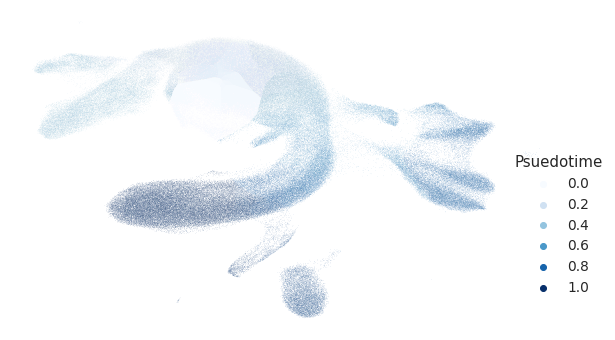

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = combined_adata.obsm['X_umap'][:,0],
                y = combined_adata.obsm['X_umap'][:,1], 
                hue = combined_adata.obs.integrated_ps,
                palette='Blues',

                s = 20000/combined_adata.shape[0],
                rasterized=True,
                alpha=1,
                ax=ax)
ax.axis('off')
ax.legend(loc=(.9,.1), frameon=False,title='Psuedotime')
plt.savefig('/home/bharris/pseudotime/figures/supplements/integrated_pseudotime_umap.pdf',
            transparent=True)


## Compare Pseudotimes

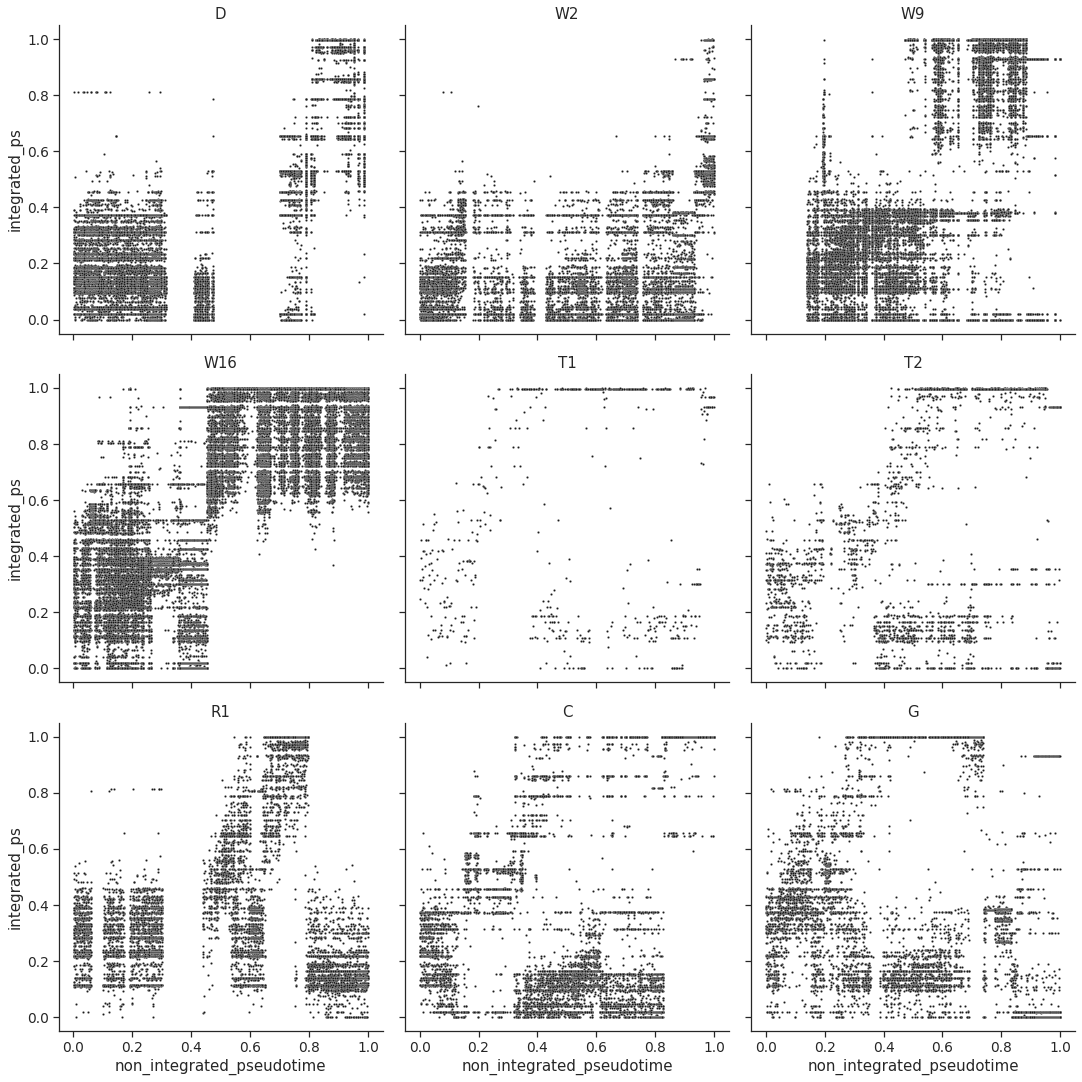

In [38]:
combined_adata.obs['Study'] = [x[0].upper() + ''.join(re.findall(r'\d+',x)) for x in combined_adata.obs.study_id]
g=sns.relplot(data=combined_adata.obs,
            x='non_integrated_pseudotime',
            y='integrated_ps',
            rasterized=True,
            col='Study',
            kind='scatter',
              color='k',
              s=5,
           col_wrap=3)
g.set_titles('{col_name}')
g.set_axis_labels(xlabel='Individual Dataset Pseudotime',ylabel='Integrated Pseudotime')
plt.savefig('/home/bharris/pseudotime/figures/supplements/integrated_pseudotime_scatter.pdf',
            transparent=True)